<h1><center>ANALYSIS OF CROP DAMAGE FROM HAIL </center></h1>

This notebook provides a workflow to obtain crop land areas affected by hail. Calculation of indices such as NDVI and NDWIg are presented. To run this notebook, it is required to have user credentials of Sentinel Hub (https://www.sentinel-hub.com/). 

The selected study case is located in Assiniboia, Saskatchewan, Canada, where a hail event occurred on July 4th, 2020. 

# 1. Set initial configuration 

In [1]:
#Verify client configuration credentials
from sentinelhub import SHConfig

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

# 2. Imports

In [2]:
#Import libraries that will be used in the workflow 
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from utils import plot_image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotImage import *

from sentinelhub import (
    SentinelHubStatistical,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    Geometry, 
    SHConfig, 
    parse_time, 
    parse_time_interval, 
    SentinelHubStatisticalDownloadClient    
)

# 3. NDVI calculation


The Normalized Difference Vegetation Index (NDVI) is an indicator of plant nitrogen content, health and yield (1). The estimation of this index is based on a band ratio between the RED (Sentinel-2 Band 4) and NIR (Sentinel-2 Band 8) bands as follows: (NIR - RED)/(NIR + RED). As a result, an index in the scale of -1 to +1 is retrieved, where higher values correspond to better plant health conditions. After obtaining the NDVI, an analysis of change between the pre-hail event image and the post-hail event images was applied by calculating the following formula: (NDVIprehail - NDVIposthail)/(NDVIprehail + NDVIposthail). The results were obtained on a scale of -1 to +1 as well, meaning that values further from zero and closer to -1 or +1 experienced higher magnitudes of change (1).

In [4]:
#evalscript for ndvi calculation
evalscript_ndvi = """
    VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B04", "B08"],
          units: "DN"
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    
    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
      return [ ndvi ]     
}   
"""


In [5]:
#Set the boundaries of the study area (UTM 13N)
bbox = BBox(bbox=[409215.60, 5490996.56, 433052.18, 5502052.76], crs=CRS('32613'))

### 3.1 NDVI calculation before the occurence of the event (July 3) 

NDVI was calculated from a day before the hail event, the image has optimal conditions without cloud coverage over the analyzed area.

In [6]:
#Image request from 2020-07-03 and application ndvi 
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-03', '2020-07-03'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response = request.get_data()

### 3.2 NDVI calculation after the occurrence of the event (July 6, 16, 28) 
Three dates were selected to assess the impact of hail over time. These images were chosen due to the limited or nonexistent cloud coverage over the area.

In [7]:
#Image request from 2020-07-06 and application ndvi
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-06', '2020-07-06'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response1 = request.get_data()

In [8]:
#Image request from 2020-07-16 and application ndvi
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-16', '2020-07-16'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response2 = request.get_data()

In [9]:
#Image request from 2020-07-28 and application ndvi
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-28', '2020-07-28'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response3 = request.get_data()

### 3.3. Change detection 
As described previously, the magnitude of change was calculated based on the formula: (NDVIprehail - NDVIposthail)/(NDVIprehail + NDVIposthail). Then, a threshold was applied to discriminate the area that was affected from the one that was not affected. The values that corresponded with damaged crops were defined in the range of above or equal to 0.15 and below or equal to 0.33. Finally, a binary map with values of 1 and 0 was generated. The estimation of the affected area was made over the pixels with value 1.

In [10]:
#Application of formula (NDVIprehail - NDVIposthail)/(NDVIprehail + NDVIposthail) to define the change
NDVIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
NDVIchange03_16 = (response[0]-response2[0])/((response[0]+response2[0]))
NDVIchange03_28 = (response[0]-response3[0])/((response[0]+response3[0]))

C:\Users\lucia\AppData\Local\Temp\ipykernel_5952\3483406848.py:2: RuntimeWarning: invalid value encountered in true_divide
  NDVIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
C:\Users\lucia\AppData\Local\Temp\ipykernel_5952\3483406848.py:3: RuntimeWarning: divide by zero encountered in true_divide
  NDVIchange03_16 = (response[0]-response2[0])/((response[0]+response2[0]))


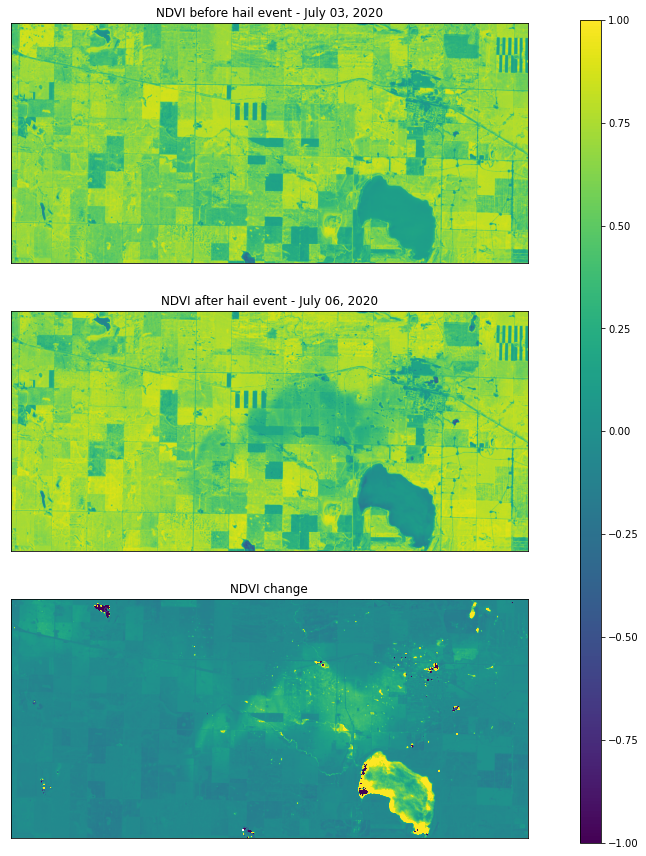

In [11]:
#Plot 3 images: pre-hail event, post-hail event (July 6) and the magnitude of change between both images
ndvi_july3 = response[0]
ndvi_july6 = response1[0]
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(ndvi_july3)
im = ax0.imshow(ndvi_july3, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDVI before hail event - July 03, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(ndvi_july6)
im2 = ax1.imshow(ndvi_july6, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDVI after hail event - July 06, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDVIchange03_06)
im3 = ax2.imshow(NDVIchange03_06, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDVI change')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

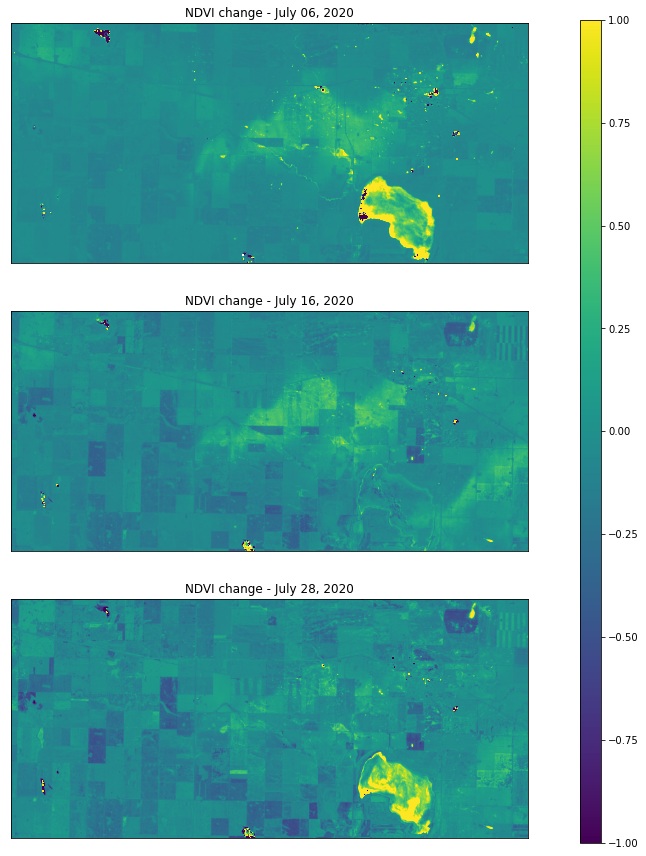

In [12]:
#Three plots that show the development of the event over time 
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    
#Plot with the magnitude of change observed in July 6 (post-event) compared to July 3 (pre-event)
im = ax0.imshow(NDVIchange03_06)
im = ax0.imshow(NDVIchange03_06, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDVI change - July 06, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

#Plot with the magnitude of change observed in July 16 (post-event) compared to July 3 (pre-event)
im2 = ax1.imshow(NDVIchange03_16)
im2 = ax1.imshow(NDVIchange03_16, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDVI change - July 16, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

#Plot with the magnitude of change observed in July 28 (post-event) compared to July 3 (pre-event)
im3 = ax2.imshow(NDVIchange03_28)
im3 = ax2.imshow(NDVIchange03_28, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDVI change - July 28, 2020')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

In [13]:
#Definition of thresholds
NDVIchange_thres06 =  np.where((NDVIchange03_06>=0.15) & (NDVIchange03_06<=0.33),1,0)
NDVIchange_thres16 =  np.where((NDVIchange03_16>=0.15) & (NDVIchange03_16<=0.33),1,0)
NDVIchange_thres28 =  np.where((NDVIchange03_28>=0.15) & (NDVIchange03_28<=0.33),1,0)

#Calculation of total number of pixes with value 1,multiplication *100 (size of pixel 10m * 10m)
count_pixels = (NDVIchange_thres06 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 06, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)

count_pixels = (NDVIchange_thres16 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 16, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)

count_pixels = (NDVIchange_thres28 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 28, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)


On July 06, the number of pixels with value 1 that represent to the affected area are: 161552 in square kilometers the affected area was: 16.1552
On July 16, the number of pixels with value 1 that represent to the affected area are: 164801 in square kilometers the affected area was: 16.4801
On July 28, the number of pixels with value 1 that represent to the affected area are: 109229 in square kilometers the affected area was: 10.9229


[]

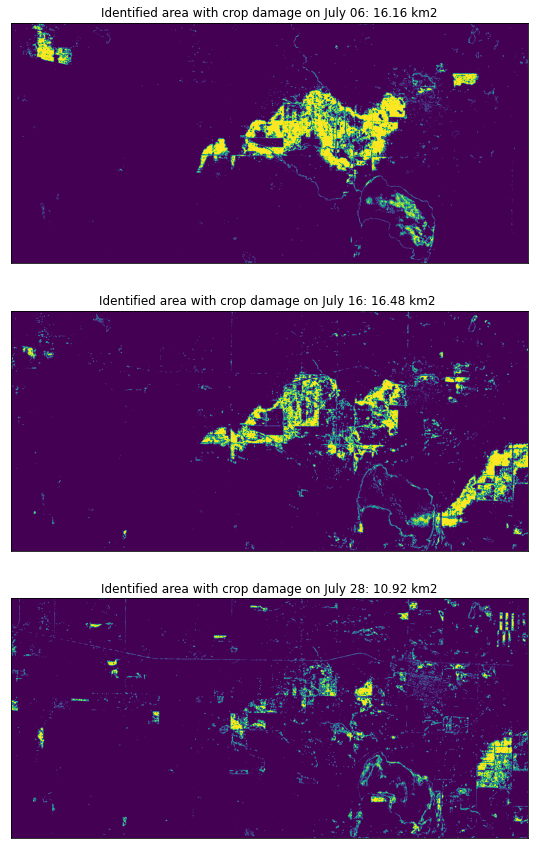

In [14]:
#Plots of binary maps over time (yellow = 1, purple = 0)
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(NDVIchange_thres06)
im = ax0.imshow(NDVIchange_thres06)
divider = make_axes_locatable(ax0)
ax0.set_title('Identified area with crop damage on July 06: 16.16 km2')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(NDVIchange_thres16)
im2 = ax1.imshow(NDVIchange_thres16)
divider = make_axes_locatable(ax1)
ax1.set_title('Identified area with crop damage on July 16: 16.48 km2 ')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDVIchange_thres28)
im3 = ax2.imshow(NDVIchange_thres28)
divider = make_axes_locatable(ax2)
ax2.set_title('Identified area with crop damage on July 28: 10.92 km2')
ax2.set_xticks([])
ax2.set_yticks([])


## 4. NDWIg calculation

The Green Normalized Difference Water Index (NDWIg) is an indicator of crop water content and used for crop yield prediction, crop evaporation and water stress (1). The estimation of this index is based on a band ratio between the Green (Sentinel-2 Band 3) and NIR (Sentinel-2 Band 8) bands as follows: (Green - NIR)/(Green + NIR). As a result, an index in the scale of -1 to +1 is retrieved. After obtaining the NDWIg, an analysis of change between the pre-hail event image and the post-hail event images was applied by calculating the following formula: (NDWIprehail - NDWIposthail)/(NDWIprehail + NDWIposthail). The results were obtained on a scale of -1 to +1 as well, meaning that values further from zero and closer to -1 or +1 experienced higher magnitudes of change. However, it is recommeded to test the analysis using the NDWI index based on the calculation of the NIR and SWIR bands. A recent study discussed about the better performance of NDWI compared to NDWIg to distinguish water features mixed with vegetation (1).

In [15]:
#evalscript for ndwig calculation
evalscript_ndwi = """
    VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B03", "B08"],
          units: "DN"
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    
    function evaluatePixel(sample) {
      let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08)
      return [ ndwi ]     
}   
"""


### 4.1 NDWIg calculation before the occurence of the event (July 3) 

NDWIg was calculated from a day before the hail event, the image has optimum conditions without cloud coverage over the analyzed area. 

In [16]:
#Image request from 2020-07-03 and application ndwig 

request = SentinelHubRequest(
    evalscript=evalscript_ndwi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-03', '2020-07-03'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response = request.get_data()


### 4.2 NDWIg calculation after the occurrence of the event (July 6, 16, 28) 
Three dates were selected to assess the impact of hail over time. These images were chosen due to the limited or nonexistent cloud coverage over the area. 

In [17]:
#Image request from 2020-07-06 and application ndwig 

request = SentinelHubRequest(
    evalscript=evalscript_ndwi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-06', '2020-07-06'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response1 = request.get_data()

In [18]:
#Image request from 2020-07-16 and application ndwig

request = SentinelHubRequest(
    evalscript=evalscript_ndwi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-16', '2020-07-16'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response2 = request.get_data()

In [19]:
#Image request from 2020-07-28 and application ndwig 

request = SentinelHubRequest(
    evalscript=evalscript_ndwi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-28', '2020-07-28'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response3 = request.get_data()

### 4.3. Change detection 
As described previously, the magnitude of change was calculated based on the formula: (NDWIprehail - NDWIposthail)/(NDWIprehail + NDWIposthail). Then, a threshold was applied to discriminate the area that was affected from the one that was not affected. The values that corresponded with damaged crops were defined in the range of above or equal to 0.09 and below or equal to 0.31. Finally, a binary map with values of 1 and 0 was generated. The estimation of the affected area was made over the pixels with value 1.

In [20]:
#Application of formula (NDWIgprehail - NDWIgposthail)/(NDWIgprehail + NDWIgposthail) to define the change

NDWIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
NDWIchange03_16 = (response[0]-response2[0])/((response[0]+response2[0]))
NDWIchange03_28 = (response[0]-response3[0])/((response[0]+response3[0]))

C:\Users\lucia\AppData\Local\Temp\ipykernel_5952\3643650985.py:1: RuntimeWarning: invalid value encountered in true_divide
  NDWIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
C:\Users\lucia\AppData\Local\Temp\ipykernel_5952\3643650985.py:3: RuntimeWarning: divide by zero encountered in true_divide
  NDWIchange03_28 = (response[0]-response3[0])/((response[0]+response3[0]))
C:\Users\lucia\AppData\Local\Temp\ipykernel_5952\3643650985.py:3: RuntimeWarning: invalid value encountered in true_divide
  NDWIchange03_28 = (response[0]-response3[0])/((response[0]+response3[0]))


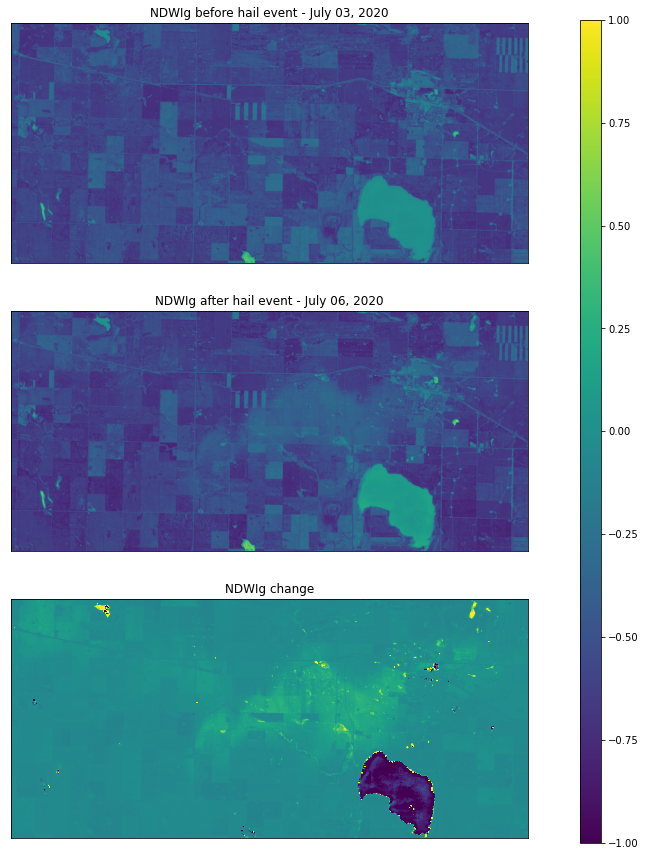

In [21]:
#Plot 3 images: pre-hail event, post-hail event (July 6) and the magnitude of change between both images

ndwi_july3 = response[0]
ndwi_july6 = response1[0]
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
  
im = ax0.imshow(ndwi_july3)
im = ax0.imshow(ndwi_july3, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDWIg before hail event - July 03, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(ndwi_july6)
im2 = ax1.imshow(ndwi_july6, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDWIg after hail event - July 06, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDWIchange03_06)
im3 = ax2.imshow(NDWIchange03_06, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDWIg change')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

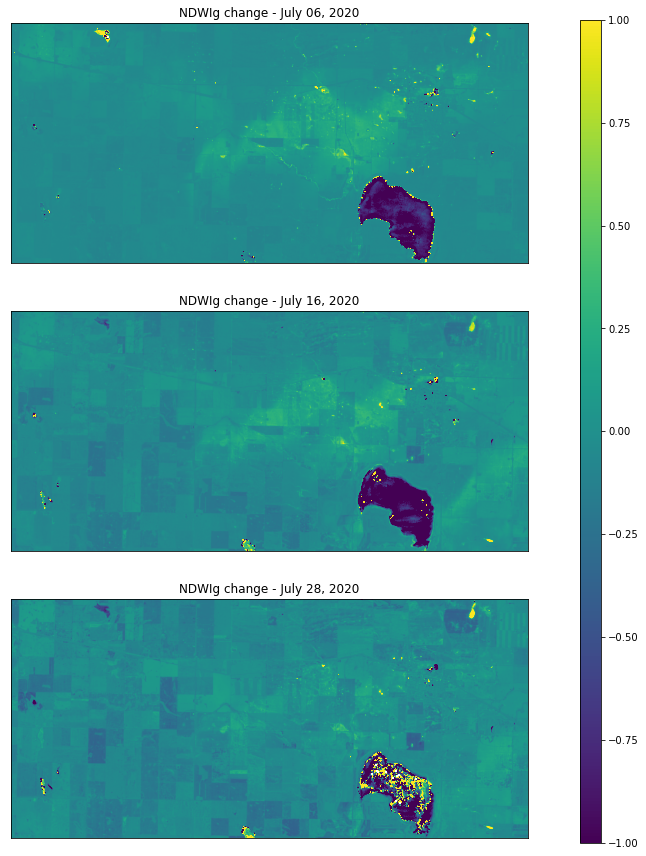

In [22]:
#Three plots that show the development of the event over time 
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    
#Plot with the magnitude of change observed in July 6 (post-event) compared to July 3 (pre-event)
im = ax0.imshow(NDWIchange03_06)
im = ax0.imshow(NDWIchange03_06, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDWIg change - July 06, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

#Plot with the magnitude of change observed in July 16 (post-event) compared to July 3 (pre-event)
im2 = ax1.imshow(NDWIchange03_16)
im2 = ax1.imshow(NDWIchange03_16, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDWIg change - July 16, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

#Plot with the magnitude of change observed in July 28 (post-event) compared to July 3 (pre-event)
im3 = ax2.imshow(NDWIchange03_28)
im3 = ax2.imshow(NDWIchange03_28, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDWIg change - July 28, 2020')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

In [23]:
#Definition of thresholds
NDWIchange_thres06 =  np.where((NDWIchange03_06>=0.09) & (NDWIchange03_06<=0.31),1,0)
NDWIchange_thres16 =  np.where((NDWIchange03_16>=0.09) & (NDWIchange03_16<=0.31),1,0)
NDWIchange_thres28 =  np.where((NDWIchange03_28>=0.09) & (NDWIchange03_28<=0.31),1,0)

#Calculation of total number of pixes with value 1,multiplication *100 (size of pixel 10m * 10m)
count_pixels = (NDWIchange_thres06 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 06, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area corresponds to:", affected_area_square_km)

count_pixels = (NDWIchange_thres16 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 16, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area corresponds to:", affected_area_square_km)

count_pixels = (NDWIchange_thres28 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 28, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area corresponds to:", affected_area_square_km)


On July 06, the number of pixels with value 1 that represent to the affected area are: 219221 in square kilometers the affected area corresponds to: 21.9221
On July 16, the number of pixels with value 1 that represent to the affected area are: 222407 in square kilometers the affected area corresponds to: 22.2407
On July 28, the number of pixels with value 1 that represent to the affected area are: 151790 in square kilometers the affected area corresponds to: 15.179


[]

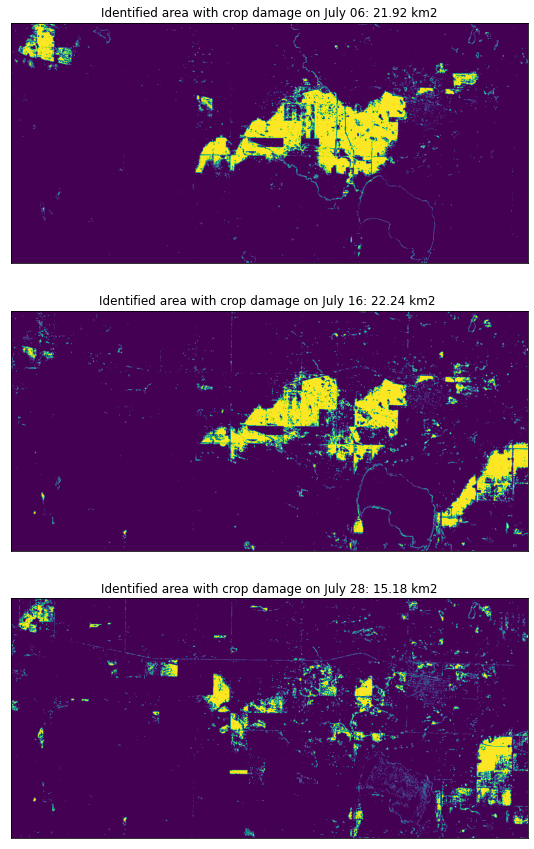

In [24]:
#Plots of binary maps over time (yellow = 1, purple = 0)
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(NDWIchange_thres06)
im = ax0.imshow(NDWIchange_thres06)
divider = make_axes_locatable(ax0)
ax0.set_title('Identified area with crop damage on July 06: 21.92 km2')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(NDWIchange_thres16)
im2 = ax1.imshow(NDWIchange_thres16)
divider = make_axes_locatable(ax1)
ax1.set_title('Identified area with crop damage on July 16: 22.24 km2 ')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDWIchange_thres28)
im3 = ax2.imshow(NDWIchange_thres28)
divider = make_axes_locatable(ax2)
ax2.set_title('Identified area with crop damage on July 28: 15.18 km2')
ax2.set_xticks([])
ax2.set_yticks([])

## 5. Conclusions

- Both indices show two main areas of impact. One located almost at the center of the image (Northwest of the pond) that is visible from July 6, and another area located in the Eastern side that is visible from July 16. The inclusion of imagery from intermediate dates into the analysis would be required to determine if the area with crop damage in the Eastern side of the study area was affected by the hail event or another natural or anthropogenic disturbance.
- The study area has a revisit time of 3 to 6 days approximately. However, not all the optical imagery is optimal for analysis due to cloud coverge. An alternative is to integrate methods such as data fusion using Sentinel-2 with Sentinel-1 SAR images to penetrate cloud coverage and increase the frequency of observations. However, it is important to take into account the limitations of this method over areas with low biomass (2). It would ease crop monitoring after the event.  
- Based on the NDVI, the extent of the affected area ranged from 10 to 16 km2, whereas the NDWIg defined a larger area in the range of 15 to 22 km2. Overall, the extent of the afected area experienced a minor increment on July 16, and later on, it reduced significantly by July 28. It is recommended to test the performance of the NDWI with the NIR and SWIR bands against the NDWIg. 
- The application of a mask of water bodies is missing on this analysis. Therefore, some under and overestimations could have arised due the application of a threshold. Additionally, this issue could be addressed by using crop field polygons to target the calculation of indices within these polygons. A resource such as the the automatic delineation tool of agricultural fields developed by Sentinel Hub in the context of the NIVA project, could very useful on this regard (3). 

## 6. References 

(1) Ha T, Shen Y, Duddu H, Johnson E, Shirtliffe SJ. Quantifying Hail Damage in Crops Using Sentinel-2 Imagery. Remote Sensing. 2022; 14(4):951. https://doi.org/10.3390/rs14040951

(2) Filgueiras R, Mantovani EC, Althoff D, Fernandes Filho EI, Cunha FFd. Crop NDVI Monitoring Based on Sentinel 1. Remote Sensing. 2019; 11(12):1441. https://doi.org/10.3390/rs11121441

(3) Automatic field delineation tool. Github rpository: https://github.com/sentinel-hub/field-delineation 